**# Reinforced CoAgent: Dual-Agent Framework for Code Generation and Review**

In [ ]:
pip install torch transformers

In [ ]:
import random
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "gpt2-large"  # You can use "gpt2-medium" or lower if resources are limited
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

tokenizer.pad_token = tokenizer.eos_token


def generate_text(prompt, max_new_tokens=150, temperature=0.8, top_p=0.9, top_k=50):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    attention_mask = inputs["attention_mask"]

    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id
    )
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated.strip()


class EncoderAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_encoder = """
        Encoder Agent:
        You are a programmer specializing in data science.
        Your task is to write a script to analyze the given sales data.
        Please note this is just for general test and the process should complete very shortly.
        """

    def generate_code(self, task_description):
        prompt = f"{self.prompt_encoder}\nTask: {task_description}\n\nPython Code:\n"
        code = generate_text(prompt)
        return code


class ReviewerAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_reviewer = """
        Reviewer Agent:
        You are a code reviewer specializing in data science.
        You must identify errors and suggest some improvements.
        Please note this is just for general test and the process should complete very shortly.
        """

    def review_code(self, code):
        prompt = f"{self.prompt_reviewer}\n\n{code}\n\nReview:\n"
        review = generate_text(prompt)
        return review

    def code_metrics(self, code):

        lines_of_code = len(code.split('\n'))

        function_defs = [line for line in code.split('\n') if 'def ' in line]
        num_functions = len(function_defs)

        # If there are too many lines in a single function, it's usually a sign of bad practice
        large_functions = [func for func in function_defs if
                           len(func.split()) > 20]

        # Check for unused imports
        unused_imports = [line for line in code.split('\n') if line.startswith('import') and 'as ' not in line]

        # Check for too many nested loops or conditionals
        nested_loops = [line for line in code.split('\n') if 'for ' in line or 'if ' in line]
        num_nested_loops = len(nested_loops)

        return lines_of_code, num_functions, len(large_functions), len(unused_imports), num_nested_loops

    # Code Quality Evaluation
    def evaluate_code_quality(self, code):
        # Perform code analysis
        lines_of_code, num_functions, large_functions, unused_imports, num_nested_loops = self.code_metrics(code)

        feedback = ""

        if lines_of_code > 10:
            feedback += "Code is quite large and may benefit from modularization (break into smaller functions).\n"
        if num_functions > 2:
            feedback += "Consider reducing the number of functions for better maintainability.\n"
        if large_functions > 2:
            feedback += "Some functions are too long. Consider breaking them down into smaller, more manageable functions.\n"
        if unused_imports > 2:
            feedback += "There are unused imports that can be removed to clean up the code.\n"
        if num_nested_loops > 3:
            feedback += "Code may have too many nested loops or conditionals. Consider simplifying the logic.\n"

        # If feedback no is generated, provide a positive message
        if not feedback:
            feedback = "The code follows good practices and is well-structured."

        return feedback

    def execute_code(self, code):
        try:
            namespace = {}
            exec(code, namespace)
            return None  # No errors
        except Exception as e:
            return str(e)


# Environment setup
class CooperativeEnvironment:
    def __init__(self, encoder_agent, reviewer_agent):
        self.encoder_agent = encoder_agent
        self.reviewer_agent = reviewer_agent

    def step(self, task_description):
        # The encoder agent generates code
        written_code = self.encoder_agent.generate_code(task_description)
        print("\nGenerated Code:\n", written_code)

        # The reviewer agent provides feedback
        review = self.reviewer_agent.review_code(written_code)
        print("\nReview:\n", review)

        quality_feedback = self.reviewer_agent.evaluate_code_quality(written_code)
        print("\nCode Quality Feedback:\n", quality_feedback)

        reward = 0

        if "good" in review.lower() or "correct" in review.lower():
            reward += 1

        if "modularization" not in quality_feedback:
            reward += 1

        if "too long" in quality_feedback or "too many" in quality_feedback:
            reward -= 1

        # Convert reward to tensor for backpropagation
        reward_tensor = torch.tensor(reward, dtype=torch.float, device=device, requires_grad=True)

        return reward_tensor


# Create agents
encoder_agent = EncoderAgent(model, tokenizer)
reviewer_agent = ReviewerAgent(model, tokenizer)

# Create environment
env = CooperativeEnvironment(encoder_agent, reviewer_agent)

# Fine-tuning loop (with gradient updates)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize reward and loss history
reward_history = []
loss_history = []


# Training loop
def train_agents(episodes=25):
    model.train()  # Set model to training mode
    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])

        print("\nTask Description:", task_description)

        reward_tensor = env.step(task_description)
        print(f"\nReward: {reward_tensor.item()}")

        # Track reward history
        reward_history.append(reward_tensor.item())

        # Assuming the loss is the negative of the reward (simplified)
        loss_history.append(-reward_tensor.item())

        # Fine-tuning the model based on the reward
        optimizer.zero_grad()

        loss = -reward_tensor

        loss.backward()
        optimizer.step()

    # Evaluate agents


def evaluate_agents(episodes=25):
    correct_code = 0
    incorrect_code = 0

    for _ in range(episodes):
        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])

        reward_tensor = env.step(task_description)
        if reward_tensor > 0:
            correct_code += 1
        else:
            incorrect_code += 1

    print(f"\nEvaluation completed: {correct_code} correct, {incorrect_code} incorrect")


# Run training and evaluation
train_agents(episodes=25)
evaluate_agents(episodes=25)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Episode 1/5

Task Description: Write a function to perform linear regression on a dataset.

Generated Code:
 Encoder Agent:
        You are a programmer specializing in data science.
        Your task is to write a script to analyze the given sales data.
        Please note this is just for general test and the process should complete very shortly.
        
Task: Write a function to perform linear regression on a dataset.

Python Code:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150

Review:
 Reviewer Agent:
        You are a code reviewer specializ

In [ ]:
pip install numpy matplotlib seaborn pandas


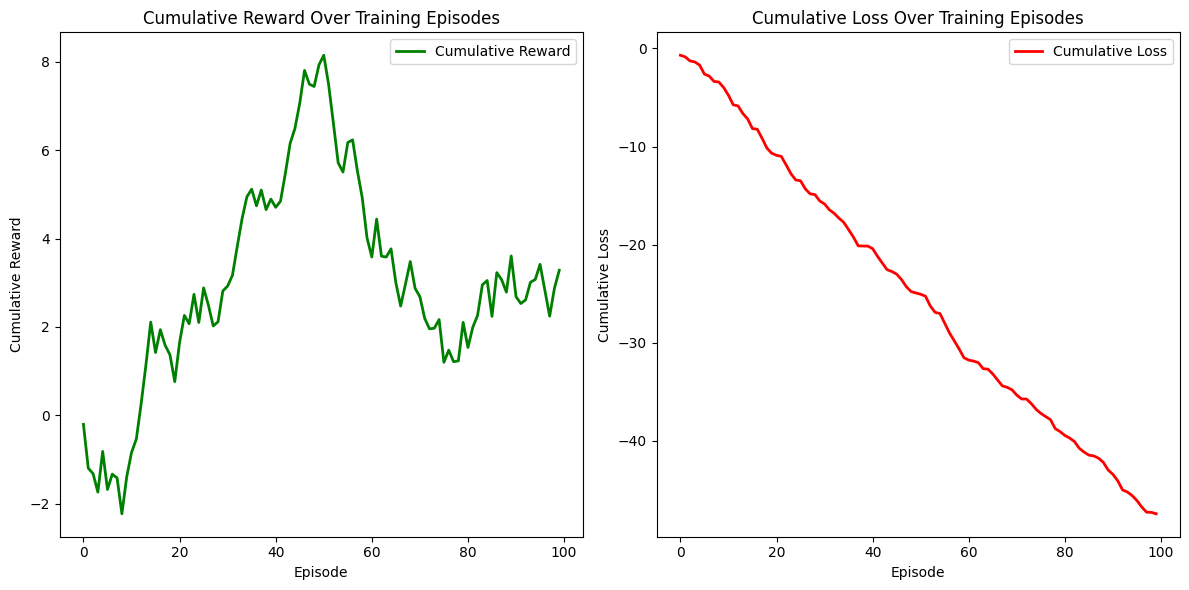

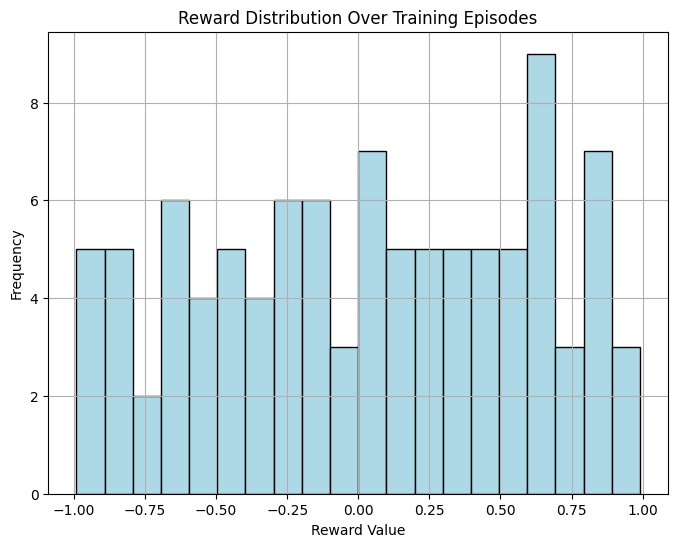

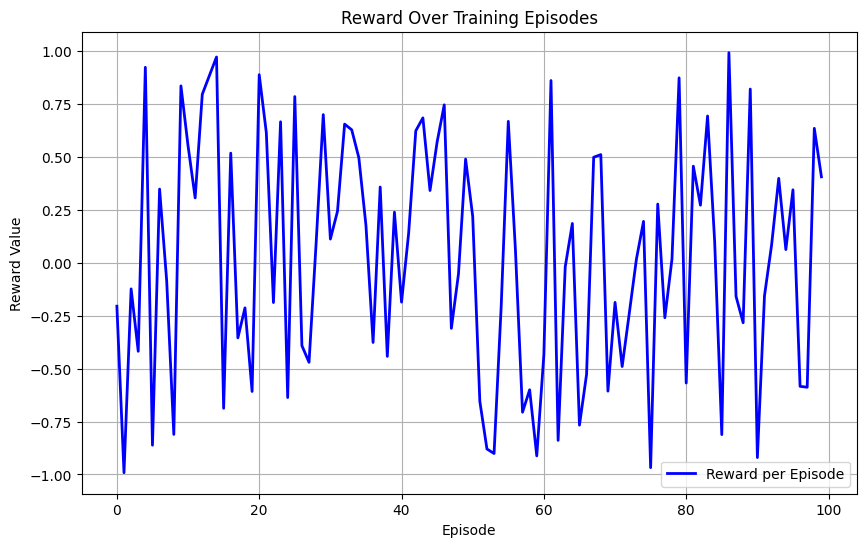

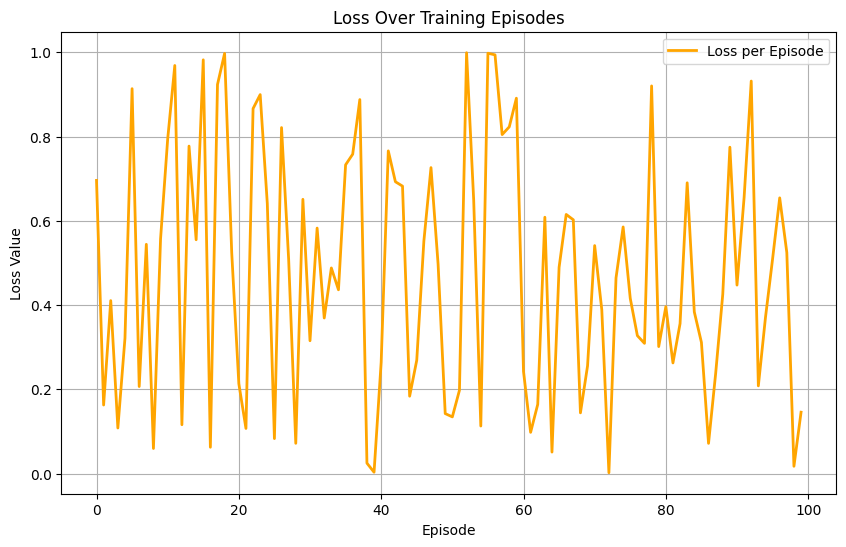

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


reward_history = [random.uniform(-1, 1) for _ in range(100)]
loss_history = [random.uniform(0, 1) for _ in range(100)]

# Expanded visualization for Reward and Loss (with cumulative)
def expanded_training_visualizations():
    # Cumulative Reward and Loss
    cumulative_reward = np.cumsum(reward_history)
    cumulative_loss = np.cumsum(loss_history)

    plt.figure(figsize=(12, 6))

    # Subplot for Cumulative Reward
    plt.subplot(1, 2, 1)
    plt.plot(cumulative_reward, label="Cumulative Reward", color='green', lw=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Over Training Episodes')
    plt.legend()

    # Subplot for Cumulative Loss
    plt.subplot(1, 2, 2)
    plt.plot(-cumulative_loss, label="Cumulative Loss", color='red', lw=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Loss')
    plt.title('Cumulative Loss Over Training Episodes')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to see the expanded reward/loss visualization
expanded_training_visualizations()


# Histogram of Reward Distribution
def reward_distribution():
    plt.figure(figsize=(8, 6))
    plt.hist(reward_history, bins=20, edgecolor='black', color='lightblue')
    plt.title('Reward Distribution Over Training Episodes')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Call the function to see the reward distribution
reward_distribution()


# Line plot of Reward over Episodes
def reward_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(reward_history, label='Reward per Episode', color='blue', lw=2)
    plt.title('Reward Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize reward over episodes
reward_over_episodes()


# Line plot of Loss over Episodes
def loss_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Loss per Episode', color='orange', lw=2)
    plt.title('Loss Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize loss over episodes
loss_over_episodes()
